<a href="https://colab.research.google.com/github/Abishek2820/Water-quality-prediction/blob/main/water_quality_explanatory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Water Quality Explanatory Data Analysis

## Analysis Content
* 1.[Python Libraries](#1)
* 2.[Read and Analyze Data](#2)
* 3.[Dependent Variable Analysis](#3)
* 4.[Correlation Between Features](#4)
* 5.[Distribution of Features](#5)
* 6.[Preprocessing: Missing Value Problem](#6)
* 7.[Preprocessing: Train-Test Split and Normalization](#7)
* 8.[Modelling: Decision Tree and Random Forest Classifiers](#8)
* 9.[Visualize Decision Tree](#9)
* 10.[Random Forest Hyperparameter Tuning](#10)

<a id="1"></a>
## Python Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV , RepeatedStratifiedKFold , train_test_split
from sklearn.metrics import precision_score , confusion_matrix

from sklearn import tree






/kaggle/input/water-potability/water_potability.csv


<a id="2"></a>
## Read and Analyze Data

In [ ]:
df=pd.read_csv("/kaggle/input/water-potability/water_potability.csv")

In [ ]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
df.describe()

In [ ]:
df.info()

<a id="3"></a>
## Dependent Variable Analysis

In [ ]:
d=pd.DataFrame(df["Potability"].value_counts())
fig=px.pie(d, values="Potability", names=["Not Potable", "Potable"], hole=0.4, opacity=0.8,
           labels={"label":"Potability","Potability":"Number of Samples"})
fig.update_layout(title=dict(text="Pie Chart of Potability Feature"))
fig.update_traces(textposition="outside", textinfo="percent+label")
fig.show()
          

<a id="4"></a>
## Correlation Between Features

In [ ]:
df.corr()

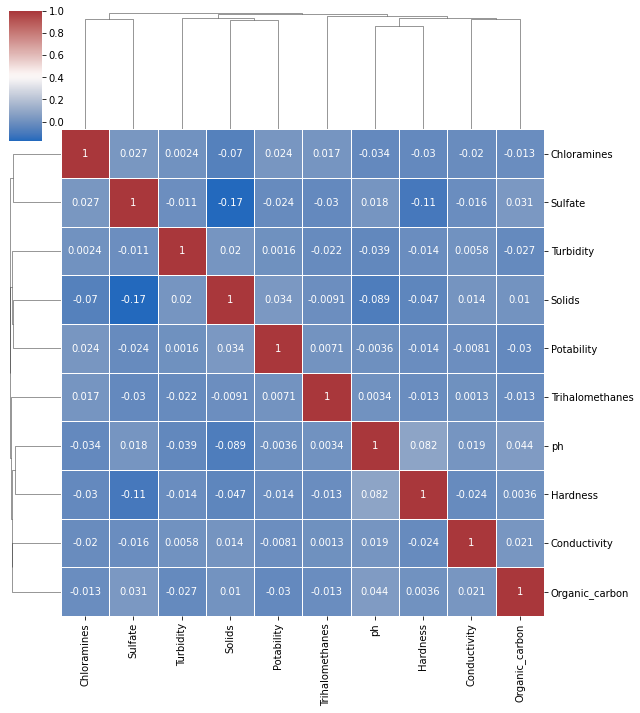

In [ ]:
sns.clustermap(df.corr(), cmap="vlag", dendrogram_ratio=(0.1,0.2), annot=True , linewidths=0.8, figsize=(9,10))
plt.show()

<a id="5"></a>
## Distribution of Features

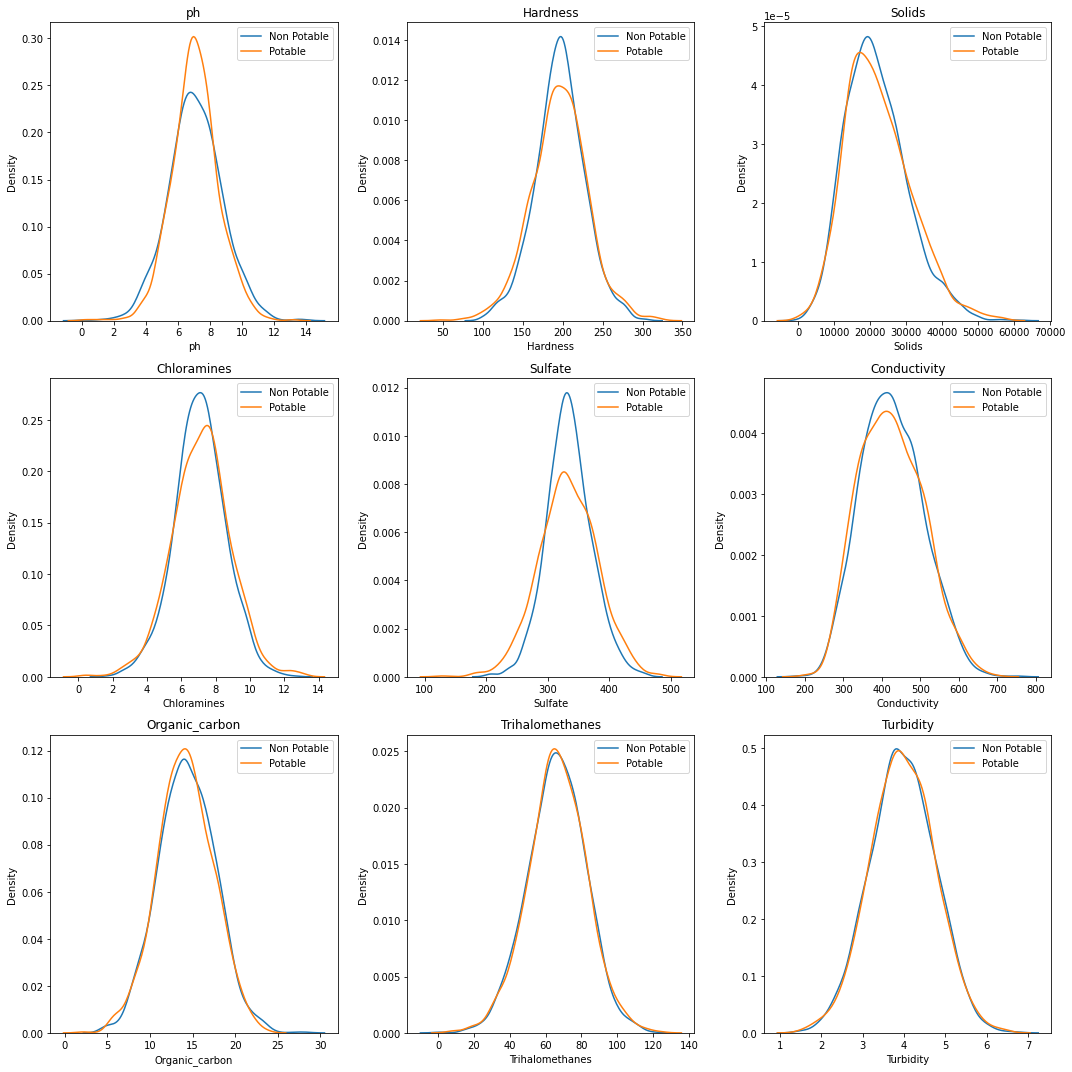

In [ ]:
non_potable=df.query("Potability==0")
potable=df.query("Potability==1")

plt.figure(figsize=(15,15))
for ax, col in enumerate(df.columns[:9]):
    plt.subplot(3,3, ax+1)
    plt.title(col)
    sns.kdeplot(x=non_potable[col], label= "Non Potable")
    sns.kdeplot(x=potable[col], label="Potable")
    plt.legend()
    
    

    
plt.tight_layout()

<a id="6"></a>
## Preprocessing: Missing Value Problem

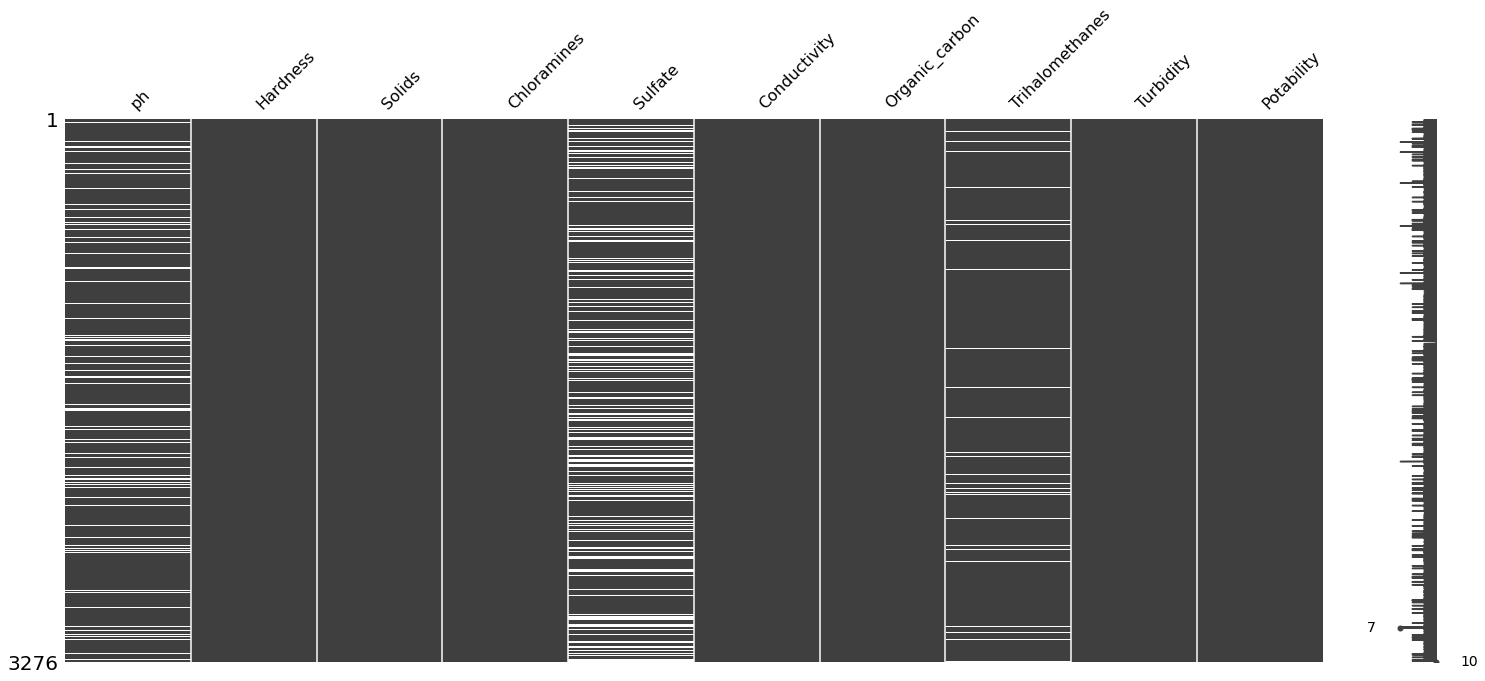

In [ ]:
msno.matrix(df)
plt.show()

In [ ]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
df["ph"].fillna(value=df["ph"].mean(), inplace=True)
df["Sulfate"].fillna(value=df["ph"].mean(), inplace=True)
df["Trihalomethanes"].fillna(value=df["ph"].mean(), inplace=True)

In [ ]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

<a id="7"></a>
## Preprocessing: Train-Test Split and Normalization

In [ ]:
X=df.drop("Potability", axis=1).values
y=df["Potability"].values

X_train, X_test , y_train , y_test=train_test_split(X,y,test_size=0.3, random_state=3)
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

X_train (2293, 9)
X_test (983, 9)
y_train (2293,)
y_test (983,)


In [ ]:
x_train_max=np.max(X_train)
x_train_min=np.min(X_train)
X_train=(X_train- x_train_min)/(x_train_max-x_train_min)
X_test=(X_test- x_train_min)/(x_train_max- x_train_min)

<a id="8"></a>
## Modelling: Decision Tree and Random Forest Classifiers

In [ ]:
models= [("DTC", DecisionTreeClassifier(max_depth=3)),
        ("RF", RandomForestClassifier())]

In [ ]:
finalResults = []
cmList = []
for name, model in models:
    model.fit(X_train,y_train)
    model_result=model.predict(X_test)
    score=precision_score(y_test,model_result)
    cm=confusion_matrix(y_test , model_result)
    
    finalResults.append((name, score))
    cmList.append((name , cm))
    
finalResults

[('DTC', 0.5398230088495575), ('RF', 0.5934579439252337)]

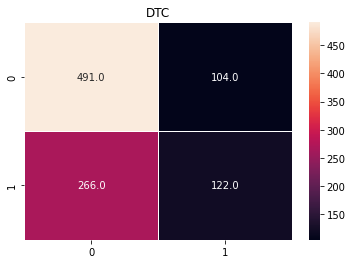

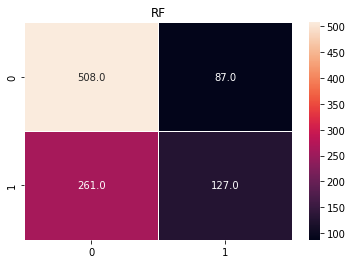

In [ ]:
for name , i in cmList:
    plt.figure()
    sns.heatmap(i , annot=True, linewidths=0.8, fmt=".1f")
    plt.title(name)
    plt.show()

<a id="9"></a>
## Visualize Decision Tree

In [ ]:
dt_clf=models[0][1]
dt_clf

DecisionTreeClassifier(max_depth=3)

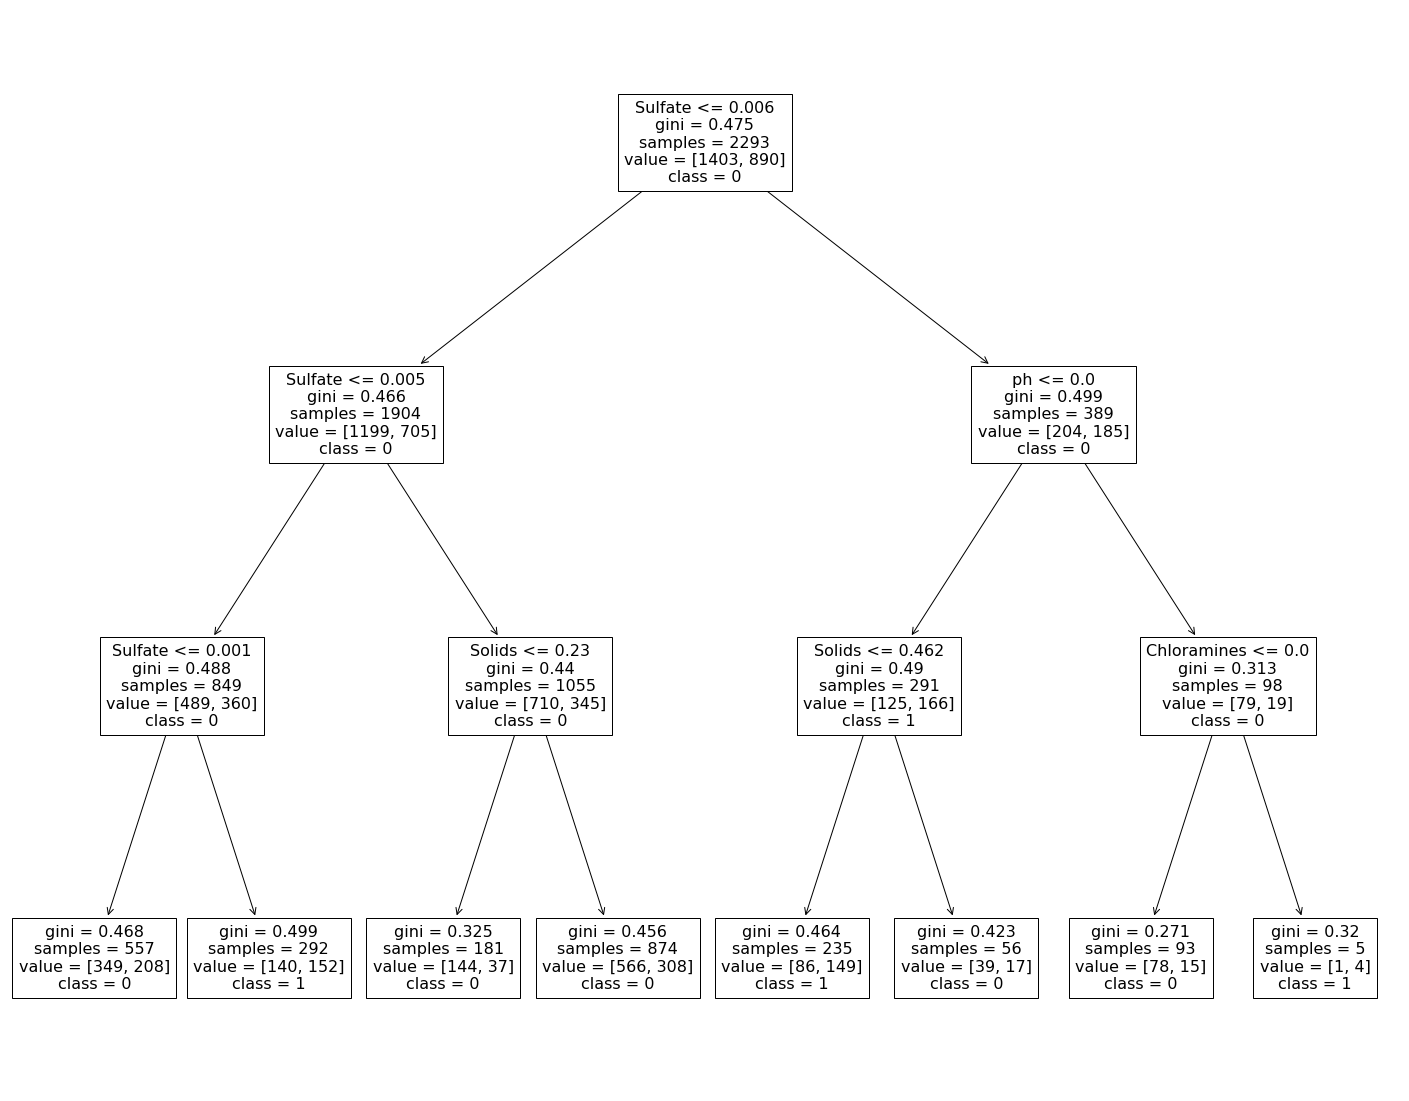

In [ ]:
plt.figure(figsize=(25,20))
tree.plot_tree(dt_clf,
              feature_names=df.columns.tolist()[:-1],
              class_names=["0" , "1"])
plt.show()

<a id="10"></a>
## Random Forest Hyperparameter Tuning

In [ ]:
model_params={
    "Random Forest":
    {
        "model":RandomForestClassifier(),
        "params":
        {
            "n_estimators":[10,50,100],
            "max_features":["auto","sqrt","log2"],
            "max_depth":list(range(1,15,3))
            
        }
    }
}

model_params

{'Random Forest': {'model': RandomForestClassifier(),
  'params': {'n_estimators': [10, 50, 100],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth': [1, 4, 7, 10, 13]}}}

In [ ]:
cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
scores=[]
for model_name , params in model_params.items():
    rs=RandomizedSearchCV(params["model"], params["params"], cv=cv , n_iter=10)
    rs.fit(X,y)
    scores.append([model_name,dict(rs.best_params_), rs.best_score_])
    
scores

[['Random Forest',
  {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 10},
  0.6570533885682368]]